In [1]:
library(eurostat)
library(ggplot2)
library(corrplot)
library(vtable)
library(cowplot)
library(moments)
library(e1071)

options(width=160, repr.plot.width=11, repr.plot.height=8)     

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
corrplot 0.92 loaded

Loading required package: kableExtra


Attaching package: ‘e1071’


The following objects are masked from ‘package:moments’:

    kurtosis, moment, skewness




# Úkoly

V tomto úkolu provedete analýzu datasetu z Eurostatu. Přístup k datům umožňuje balík [eurostat](https://ropengov.github.io/eurostat/articles/eurostat_tutorial.html). Počátečními kroky vás skript provede, následně bude práce na vás.

Vybereme si např. data, která obsahují slovo "heating":

In [2]:
search_eurostat(pattern='heating')

title,code,type,last update of data,last table structure change,data start,data end,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cooling and heating degree days by NUTS 3 regions - annual data,nrg_chddr2_a,dataset,01.02.2023,01.02.2023,1979,2022,NA
Cooling and heating degree days by NUTS 3 regions - monthly data,nrg_chddr2_m,dataset,01.02.2023,01.02.2023,1979M01,2022M12,NA
Use of renewables for heating and cooling - details,nrg_ind_urhcd,dataset,27.01.2023,27.01.2023,2004,2020,NA
Cooling and heating degree days by country - annual data,nrg_chdd_a,dataset,01.02.2023,01.02.2023,1979,2022,NA
Cooling and heating degree days by country - monthly data,nrg_chdd_m,dataset,01.02.2023,01.02.2023,1979M01,2022M12,NA
Cooling and heating degree days by NUTS 3 regions - annual data,nrg_chddr2_a,dataset,01.02.2023,01.02.2023,1979,2022,NA
Cooling and heating degree days by NUTS 3 regions - monthly data,nrg_chddr2_m,dataset,01.02.2023,01.02.2023,1979M01,2022M12,NA
Cooling and heating degree days by NUTS 3 regions - monthly data,nrg_chddr2_m,dataset,01.02.2023,01.02.2023,1979M01,2022M12,NA
Cooling and heating degree days by NUTS 3 regions - annual data,nrg_chddr2_a,dataset,01.02.2023,01.02.2023,1979,2022,NA


Dostali jsme tabulku, v níž je přehled datových sad s klíčovým slovem, plus pár údajů. Pro stažení datasetu je potřeba jeho identifikátor - `code`. Stáhneme si vybraný dataset:

In [3]:
id <- 'nrg_chddr2_a'
dat <- get_eurostat(id=id)
head(dat)

Table nrg_chddr2_a cached at /tmp/RtmpdZppJt/eurostat/nrg_chddr2_a_date_code_FF.rds



unit,indic_nrg,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
NR,CDD,AT,2022-01-01,29.40
NR,CDD,AT1,2022-01-01,62.78
NR,CDD,AT11,2022-01-01,94.55
NR,CDD,AT111,2022-01-01,80.73
NR,CDD,AT112,2022-01-01,126.13
NR,CDD,AT113,2022-01-01,62.72


[Dataset](https://en.wikipedia.org/wiki/Heating_degree_day) obsahuje měřící jednotku (NR, numeric), indikátor ([CDD, HDD](https://en.wikipedia.org/wiki/Heating_degree_day)), geolokaci podle [NUTS](https://cs.wikipedia.org/wiki/NUTS), den získání dat a hodnotu.

Vybereme si nějaký z krajů [ČR](https://cs.wikipedia.org/wiki/CZ-NUTS), dále třeba [Finska](https://cs.wikipedia.org/wiki/FI-NUTS), [Norska](https://cs.wikipedia.org/wiki/NO-NUTS) a [Španělska](https://cs.wikipedia.org/wiki/ES-NUTS):

In [4]:
NUTS3 <- c('FI1D3', 'CZ031', 'NO011', 'ES230')
data <- dat[dat$geo %in% NUTS3,]
head(data)

unit,indic_nrg,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
NR,CDD,CZ031,2022-01-01,13.64
NR,CDD,ES230,2022-01-01,182.98
NR,CDD,FI1D3,2022-01-01,1.55
NR,CDD,NO011,2022-01-01,0.00
NR,HDD,CZ031,2022-01-01,3085.93
NR,HDD,ES230,2022-01-01,1984.78


Balík [eurostat](https://ropengov.github.io/eurostat/articles/eurostat_tutorial.html) umožňuje i labelování dat. To je praktické pro přehled, méně už pro práci.

In [5]:
data_labels <- label_eurostat(data)
head(data_labels)

unit,indic_nrg,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
Number,Cooling degree days,Jihocecký kraj,2022-01-01,13.64
Number,Cooling degree days,La Rioja,2022-01-01,182.98
Number,Cooling degree days,Pohjois-Karjala,2022-01-01,1.55
Number,Cooling degree days,Oslo (statistical region 2016),2022-01-01,0.00
Number,Heating degree days,Jihocecký kraj,2022-01-01,3085.93
Number,Heating degree days,La Rioja,2022-01-01,1984.78


## Úkol 1: předefinujte sloupce:
- `data$geo` na typ factor,
- `data$time` na typ Date.

Nápověda: `as.factor()`, `as.Date()`

In [6]:
data$geo <- as.factor(data$geo)
data$time <- as.Date(data$time)

In [7]:
head(data)

unit,indic_nrg,geo,time,values
<chr>,<chr>,<fct>,<date>,<dbl>
NR,CDD,CZ031,2022-01-01,13.64
NR,CDD,ES230,2022-01-01,182.98
NR,CDD,FI1D3,2022-01-01,1.55
NR,CDD,NO011,2022-01-01,0.00
NR,HDD,CZ031,2022-01-01,3085.93
NR,HDD,ES230,2022-01-01,1984.78


### Úkol 2

Upravte data (nebo vytvořte novou tabulku data) tak, by obsahovala sloupce `geo`, `time`, `cdd_vals` a `hdd_vals` s hodnotami CDD a HDD.

Nápověda: možností je více, můžete vytvořit dvě tabulky zvlášť pro CDD a pro HDD, smazat zbytečné sloupce (nastavit jim hodnotu NULL) a pak je spojit pomocí `merge()`.

In [8]:
cdd <- data[data$indic_nrg=='CDD',]
colnames(cdd)[5] <- 'cdd_vals'
cdd$indic_nrg <- NULL
cdd$unit <- NULL
hdd <- data[data$indic_nrg=='HDD',]
colnames(hdd)[5] <- 'hdd_vals'
hdd$indic_nrg <- NULL
hdd$unit <- NULL
head(hdd)

geo,time,hdd_vals
<fct>,<date>,<dbl>
CZ031,2022-01-01,3085.93
ES230,2022-01-01,1984.78
FI1D3,2022-01-01,5137.46
NO011,2022-01-01,4076.79
CZ031,2021-01-01,3465.59
ES230,2021-01-01,2275.83


In [9]:
cdd_hdd <- merge(cdd, hdd, by=c('geo', 'time'))
head(cdd_hdd)

,geo,time,cdd_vals,hdd_vals
,<fct>,<date>,<dbl>,<dbl>
1,CZ031,1979-01-01,0.00,3815.78
2,CZ031,1980-01-01,0.00,4071.20
3,CZ031,1981-01-01,0.00,3764.54
4,CZ031,1982-01-01,0.00,3622.41
5,CZ031,1983-01-01,8.59,3569.45
6,CZ031,1984-01-01,3.46,3879.15


<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 3

Vykreslete bodový graf (scatter plot) a diskutujte o vlastnostech dat. Nápověda: `pairs()`.

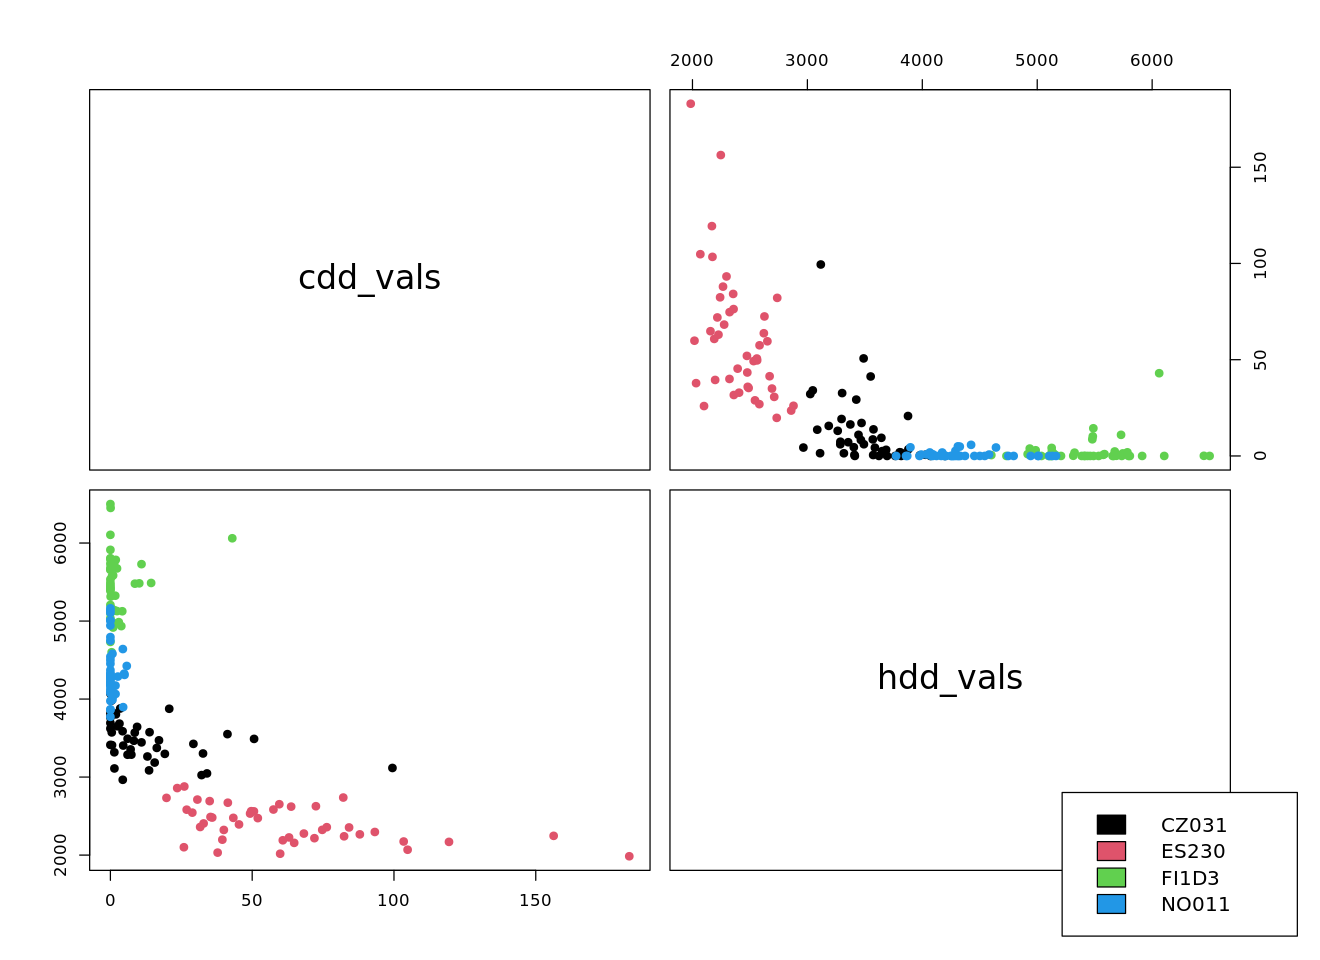

In [10]:
pairs(cdd_hdd[,3:4], col=cdd_hdd$geo, pch=19)
par(xpd = TRUE)
legend("bottomright", bty="o", y.intersp=.7, fill = unique(cdd_hdd$geo), 
       legend = c(levels(cdd_hdd$geo)))

<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 4.a: základní popisné statistiky

Věnujte se popisné statistice. Zjistěte nejdůležitější statistické míry a interpretujte je. Nápověda: `summary()`.

In [11]:
summary(cdd_hdd)

    geo          time               cdd_vals         hdd_vals   
 CZ031:44   Min.   :1979-01-01   Min.   :  0.00   Min.   :1985  
 ES230:44   1st Qu.:1989-10-01   1st Qu.:  0.00   1st Qu.:2944  
 FI1D3:44   Median :2000-07-02   Median :  2.33   Median :3936  
 NO011:44   Mean   :2000-07-02   Mean   : 19.23   Mean   :3931  
            3rd Qu.:2011-04-02   3rd Qu.: 30.93   3rd Qu.:4973  
            Max.   :2022-01-01   Max.   :182.98   Max.   :6500  

Toto nám nemusí úplně vyhovovat. Proč? 

### Úkol 4.b: základní popisné statistiky (pokr.)

Zkusíme se tedy zaměřit na detaily. Uděláme summary pro jednu z oblastí.

In [12]:
summary(cdd_hdd[cdd_hdd$geo %in% "FI1D3",])

    geo          time               cdd_vals         hdd_vals   
 CZ031: 0   Min.   :1979-01-01   Min.   : 0.000   Min.   :4600  
 ES230: 0   1st Qu.:1989-10-01   1st Qu.: 0.000   1st Qu.:5127  
 FI1D3:44   Median :2000-07-02   Median : 0.080   Median :5470  
 NO011: 0   Mean   :2000-07-02   Mean   : 2.617   Mean   :5454  
            3rd Qu.:2011-04-02   3rd Qu.: 1.965   3rd Qu.:5699  
            Max.   :2022-01-01   Max.   :42.980   Max.   :6500  

Ještě lepší může být použít `subset()`.

In [13]:
FI <- subset(cdd_hdd, geo=="FI1D3", select=-geo)
summary(FI)

      time               cdd_vals         hdd_vals   
 Min.   :1979-01-01   Min.   : 0.000   Min.   :4600  
 1st Qu.:1989-10-01   1st Qu.: 0.000   1st Qu.:5127  
 Median :2000-07-02   Median : 0.080   Median :5470  
 Mean   :2000-07-02   Mean   : 2.617   Mean   :5454  
 3rd Qu.:2011-04-02   3rd Qu.: 1.965   3rd Qu.:5699  
 Max.   :2022-01-01   Max.   :42.980   Max.   :6500  

### Úkol 4.c: základní popisné statistiky (pokr.)

Poslední varianta je použít `sumtable()`.

In [14]:
summ <- c('notNA(x)', 'mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 
          'median(x)', 'pctile(x)[75]', 'max(x)', 'IQR(x)',
          'skewness(x)', 'kurtosis(x)-3')
sumtable(cdd_hdd, out="return", summ=summ, group="geo", group.long=T)

Variable,NotNA,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
geo: CZ031,,,,,,,,,,,
cdd_vals,44,12.36,18.262,0,1.195,6.065,15.797,99.46,14.602,2.776,6.543
hdd_vals,44,3509.454,294.828,2965.18,3301.158,3480.295,3687.217,4197.79,386.06,0.252,-3.565
,,,,,,,,,,,
geo: ES230,,,,,,,,,,,
cdd_vals,44,61.165,34.163,19.78,35.76,54.735,75.108,182.98,39.348,1.51,-0.361
hdd_vals,44,2405.506,233.479,1984.78,2223.81,2376.55,2582.455,2879.21,358.645,0.112,-3.992
,,,,,,,,,,,
geo: FI1D3,,,,,,,,,,,


<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 5.a: histogramy

Vykreslete histogramy a diskutujte nad výsledky.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


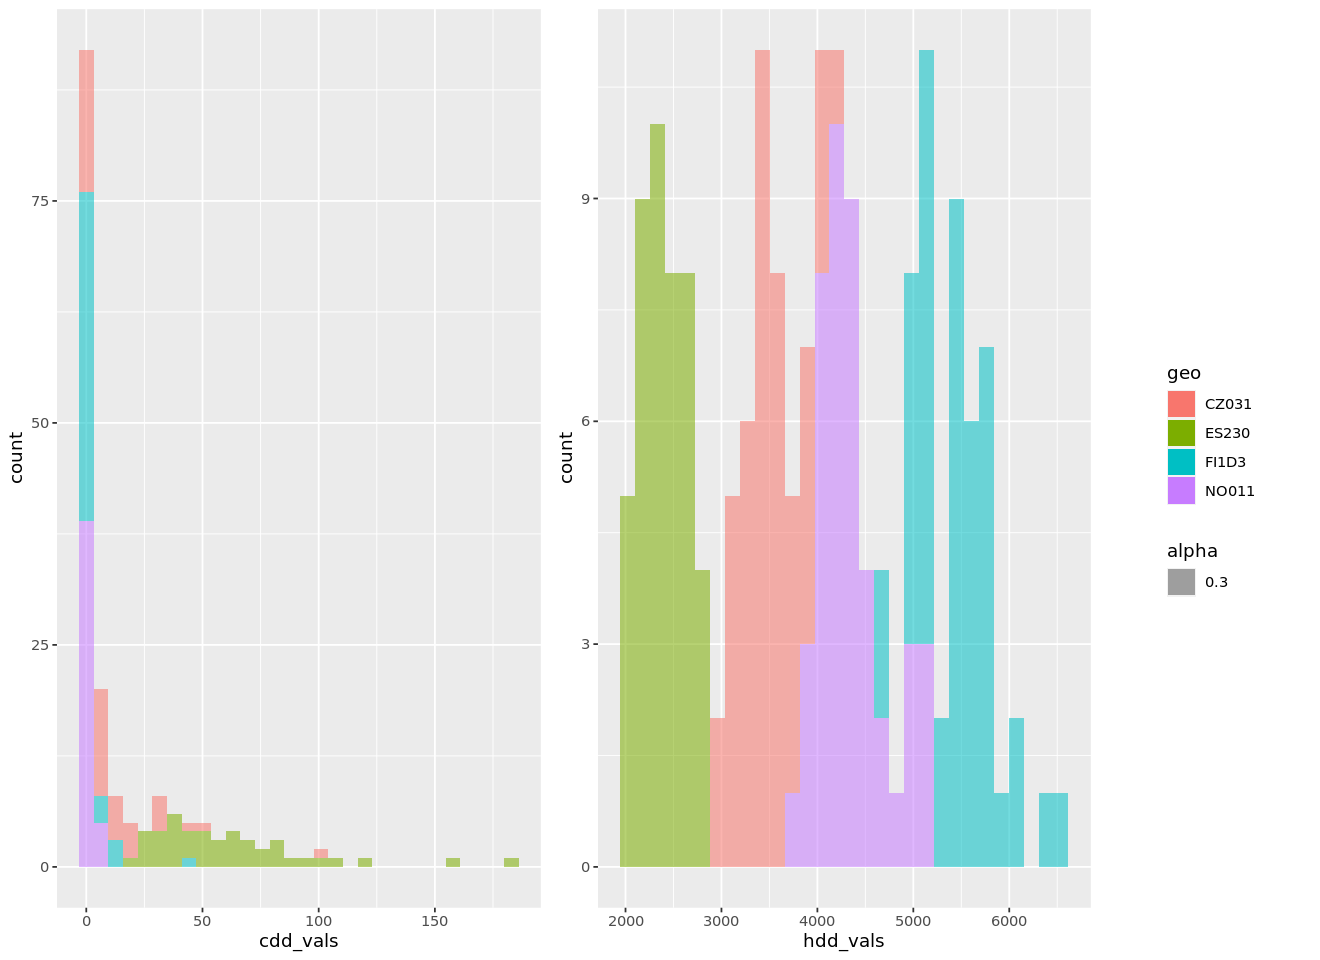

In [15]:
p1 <- ggplot(cdd_hdd, aes(x=cdd_vals, fill=geo, alpha=0.3)) +
    geom_histogram()
p2 <- ggplot(cdd_hdd, aes(x=hdd_vals, fill=geo, alpha=0.3)) +
    geom_histogram()
pg <- plot_grid(p1 + theme(legend.position="none"), 
                p2 + theme(legend.position="none"), 
                nrow=1)
legend <- get_legend(
    p1 + theme()
)
plot_grid(pg, legend, rel_widths = c(1, .2))

<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 5.b: box plot

Vykreslete boxploty a diskutujte nad výsledky. Co obsahuje boxplot?

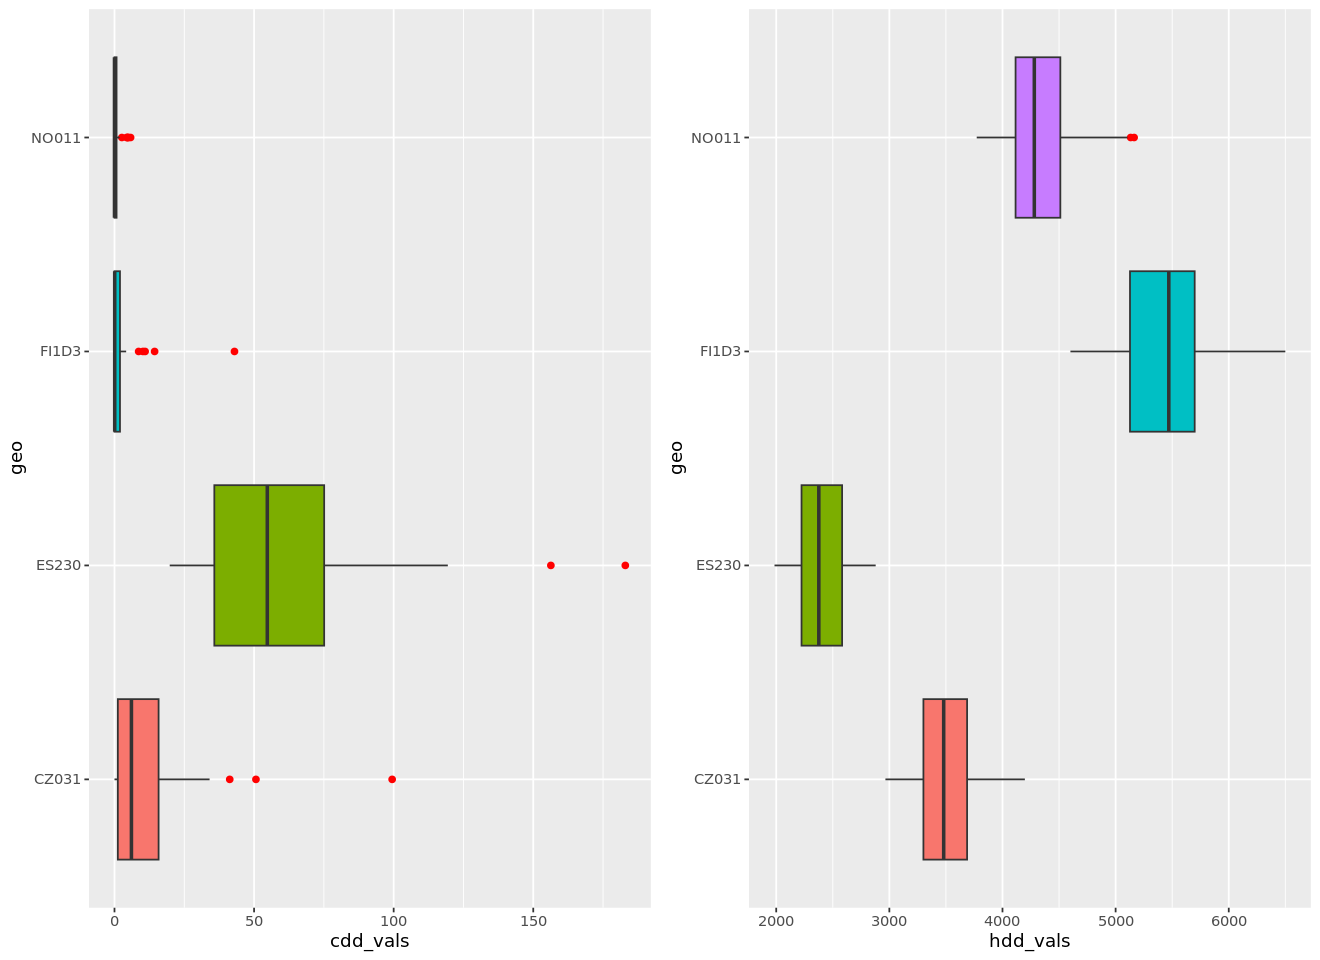

In [16]:
p1 <- ggplot(cdd_hdd, aes(x=cdd_vals, y=geo, fill=geo)) +
        geom_boxplot(outlier.color="red", show.legend=F)
p2 <- ggplot(cdd_hdd, aes(x=hdd_vals, y=geo, fill=geo)) +
        geom_boxplot(outlier.color="red", show.legend=F)
plot_grid(p1, p2, nrow=1)

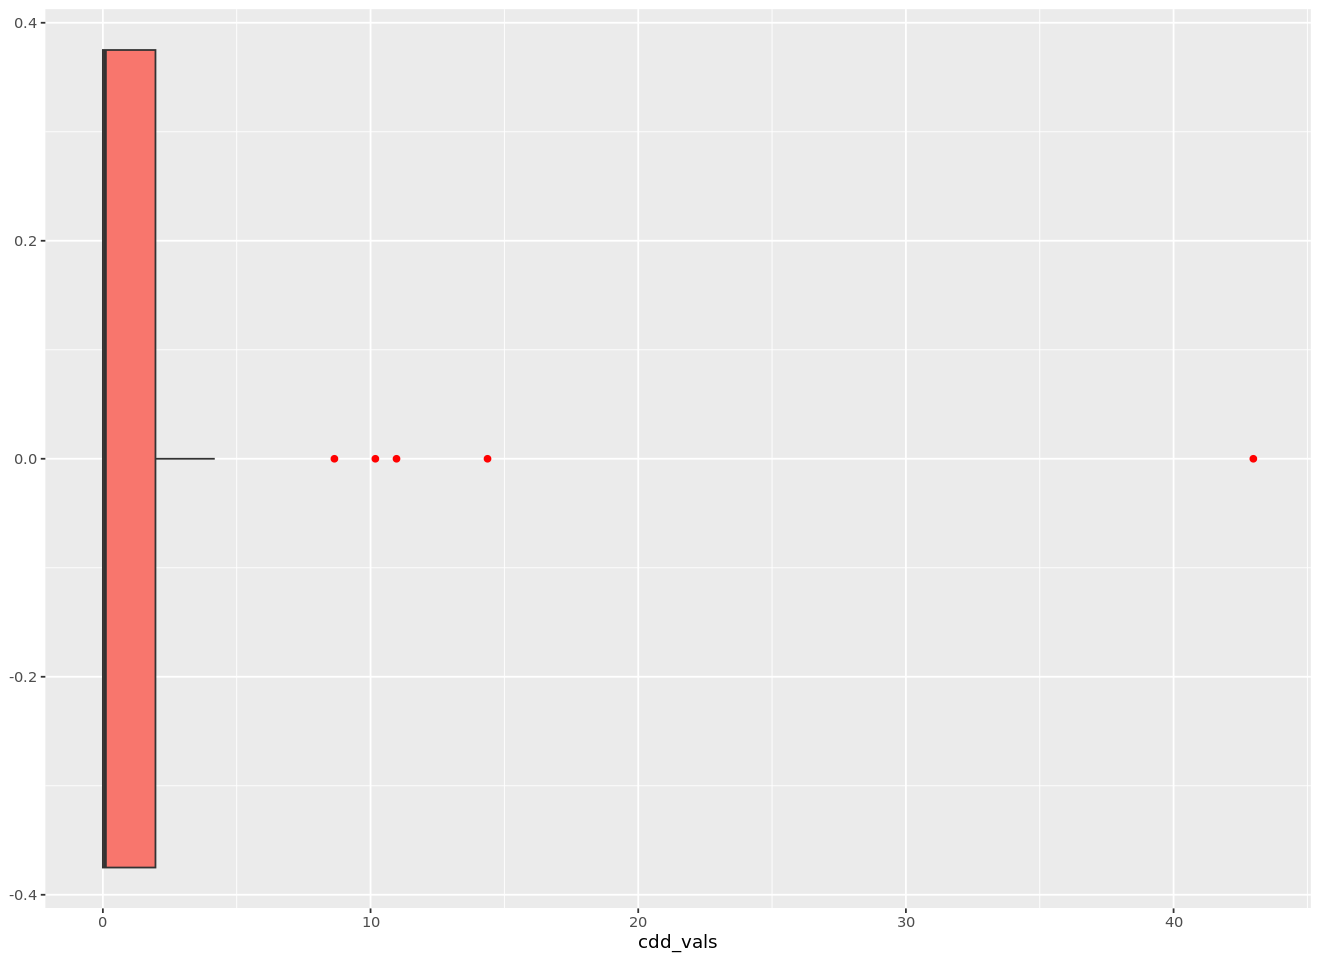

In [17]:
ggplot(FI, aes(x=cdd_vals, fill='FI')) +
       geom_boxplot(outlier.color="red", show.legend=F)

<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 5.c: houslový graf

Vykreslete houslový graf (violin plot) a interpretujte výsledky.

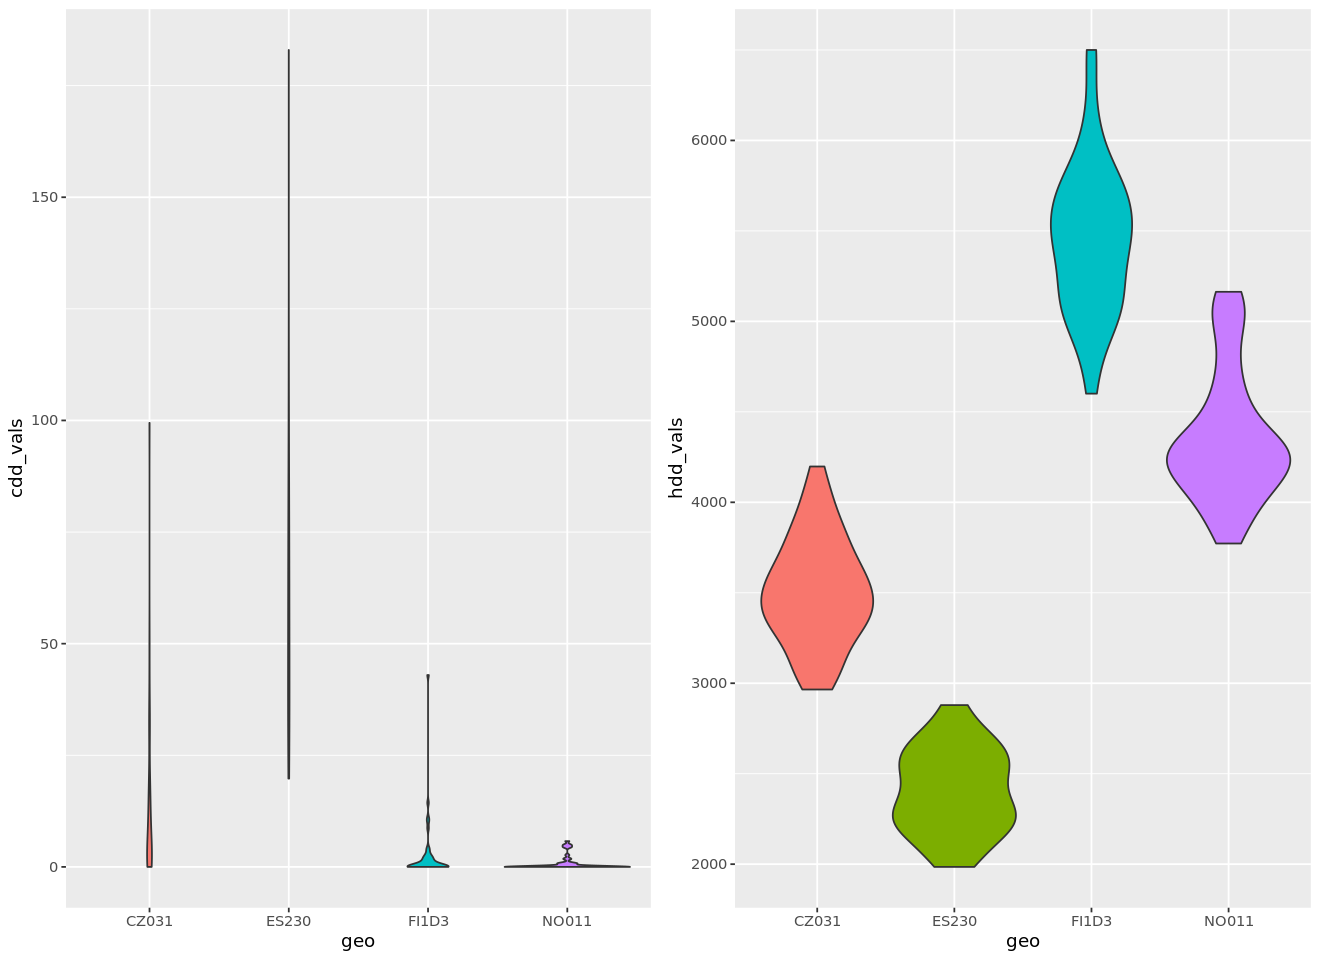

In [18]:
p1 <- ggplot(cdd_hdd, aes(x=geo, y=cdd_vals, fill=geo)) +
        geom_violin(show.legend=F)
p2 <- ggplot(cdd_hdd, aes(x=geo, y=hdd_vals, fill=geo)) +
        geom_violin(show.legend=F)
plot_grid(p1, p2, nrow=1)
# p1

<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 6.a: data CZ031

Podívejme se detailněji na data CZ031. Vykreslete v jednom obrázku histogram, KDE odhad hustoty a pro porovnání hustotu normálního rozdělení se střední hodnotou a rozptylem shodným s výběrovými statistikami dat. Diskutujte o výsledcích.
Nápověda: `geom_histogram()`, `geom_density()`, `stat_function()`.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


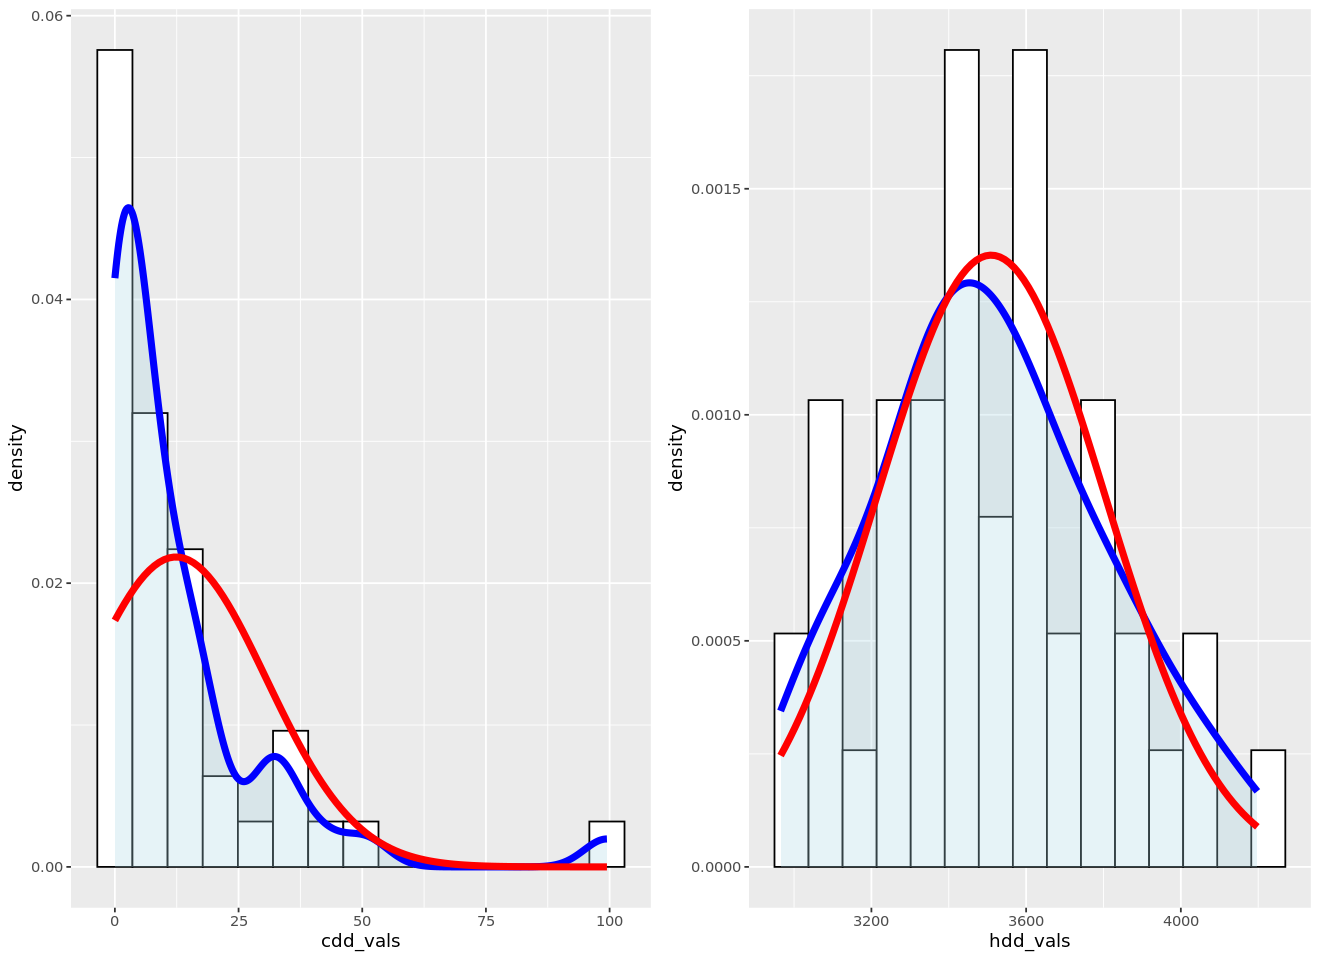

In [19]:
CZ <- subset(cdd_hdd, geo=="CZ031", select=-geo)

p1 <- ggplot(CZ, aes(x=cdd_vals)) + 
        geom_histogram(aes(y=..density..), colour = 1, fill = "white", bins=15) +
        geom_density(lwd=2, colour="blue", fill="lightblue", alpha=0.3) +
        stat_function(fun=dnorm, 
            args=list(mean=mean(CZ$cdd_vals), sd=sd(CZ$cdd_vals)),
            colour="red", lwd=2)
p2 <- ggplot(CZ, aes(x=hdd_vals)) + 
        geom_histogram(aes(y=..density..), colour = 1, fill = "white", bins=15) +
        geom_density(lwd=2, colour="blue", fill="lightblue", alpha=0.3) +
        stat_function(fun=dnorm, 
            args=list(mean=mean(CZ$hdd_vals), sd=sd(CZ$hdd_vals)),
            colour="red", lwd=2)
plot_grid(p1, p2)

### Úkol 6.b: data CZ031 (pokr.)

Proveďte analýzu normality pomocí Q-Q plotu. Nápověda: `stat_qq()`, `stat_qq_line()`.

Warning message:
“Computation failed in `stat_qq()`
Caused by error in `distribution()`:
! could not find function "distribution"”
Warning message:
“Computation failed in `stat_qq_line()`
Caused by error in `distribution()`:
! could not find function "distribution"”
Warning message:
“Computation failed in `stat_qq()`
Caused by error in `distribution()`:
! could not find function "distribution"”
Warning message:
“Computation failed in `stat_qq_line()`
Caused by error in `distribution()`:
! could not find function "distribution"”


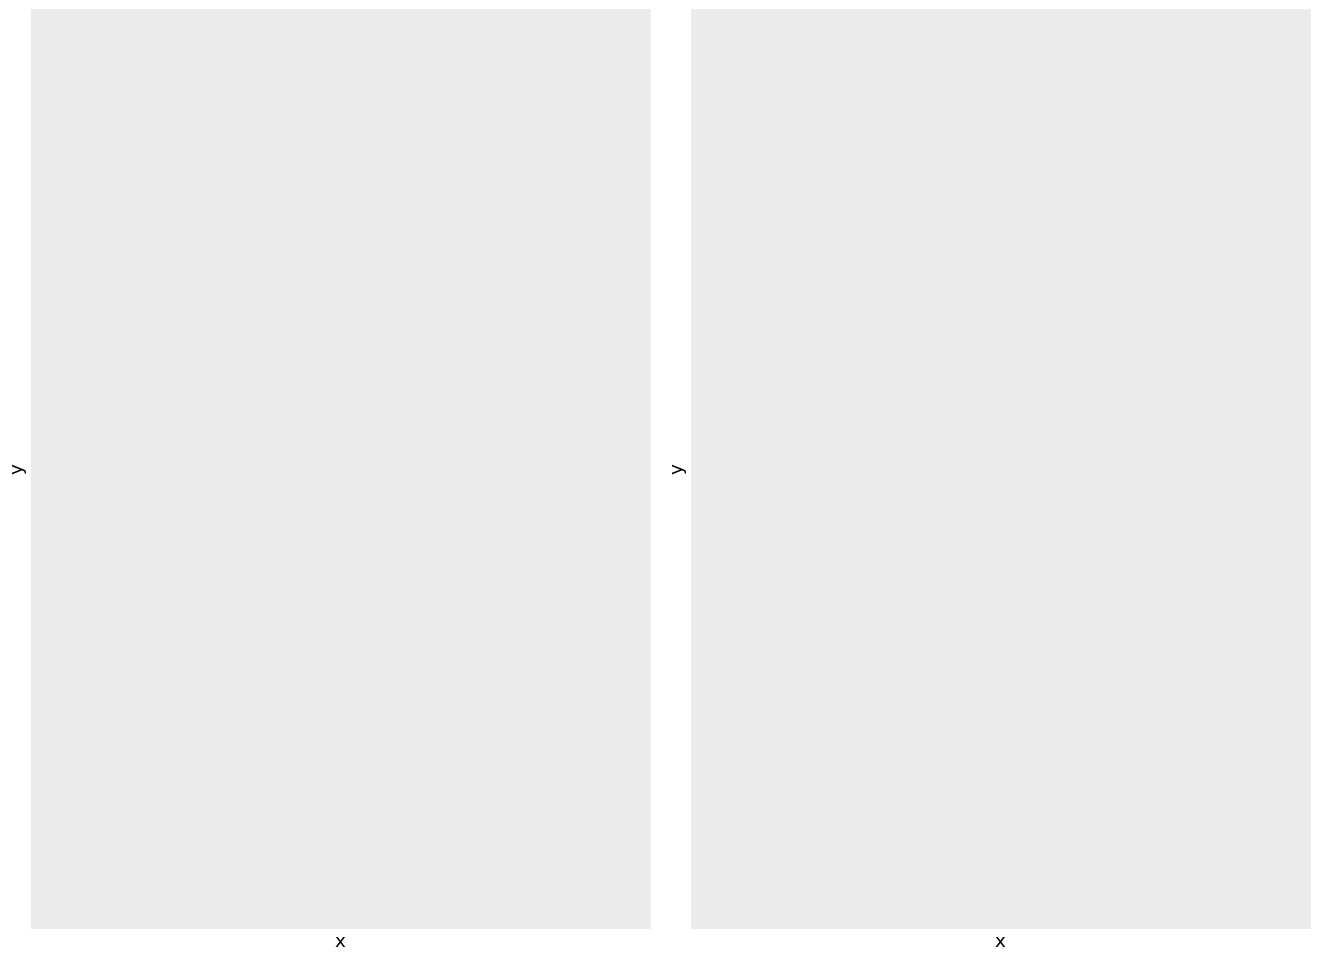

In [20]:
p1 <- ggplot(CZ, aes(sample=cdd_vals)) +
        stat_qq(distribution='qnorm', show.legend=T) +
        stat_qq_line(distribution='qnorm', show.legend=F)
p2 <- ggplot(CZ, aes(sample=hdd_vals)) +
        stat_qq(distribution='qnorm', show.legend=T) +
        stat_qq_line(distribution='qnorm', show.legend=F)
plot_grid(p1, p2, nrow=1)

### Úkol 6.c: data CZ031 (pokr.)

Určete kvantily téhož datasetu a interpretujte opět Q-Q plot.

In [21]:
summary(CZ)

      time               cdd_vals         hdd_vals   
 Min.   :1979-01-01   Min.   : 0.000   Min.   :2965  
 1st Qu.:1989-10-01   1st Qu.: 1.195   1st Qu.:3301  
 Median :2000-07-02   Median : 6.065   Median :3480  
 Mean   :2000-07-02   Mean   :12.360   Mean   :3509  
 3rd Qu.:2011-04-02   3rd Qu.:15.797   3rd Qu.:3687  
 Max.   :2022-01-01   Max.   :99.460   Max.   :4198  

### Úkol 6.d: data CZ031 (pokr.)

Otestujte normalitu pomocí Shapirova-Wilkova testu. Příslušnou funkci zkuste najít sami, interpretujte výsledky.

In [22]:
shapiro.test(CZ$hdd_vals)


	Shapiro-Wilk normality test

data:  CZ$hdd_vals
W = 0.98411, p-value = 0.7962


<font color="blue">**Nyní zpět k výkladu.**</font>

---

### Úkol 7.a: Korelační analýza

Proveďte korelační analýzu. Určete hodnoty korelačních koeficientů a interpretujte je. Použijte funkci `ggpairs()` z balíčku `GGally()`.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


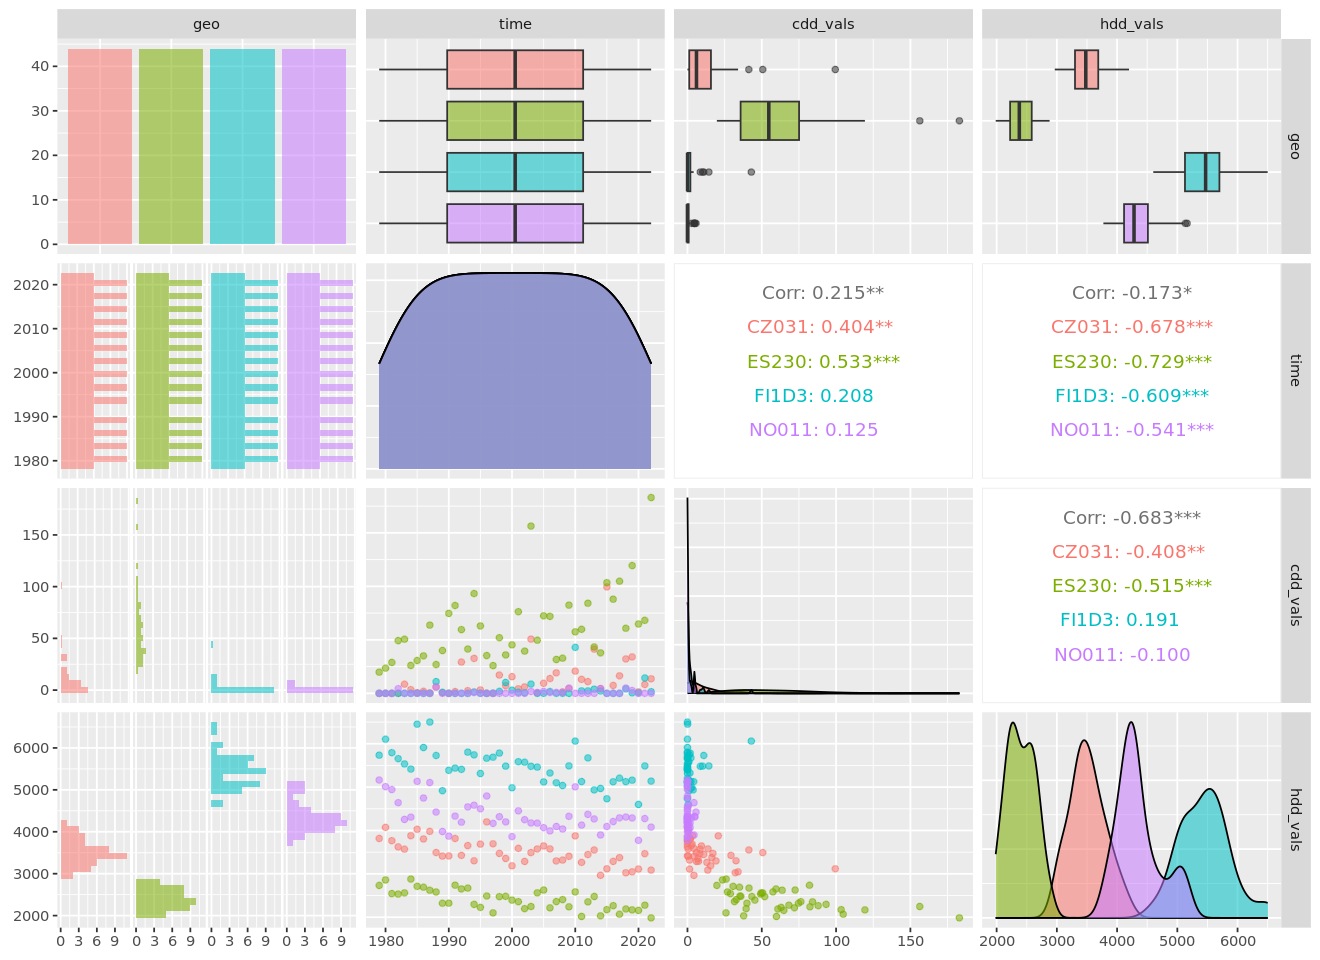

In [23]:
library(GGally)
ggpairs(cdd_hdd, ggplot2::aes(col=geo, alpha=.2))

### Úkol 7.b: korelační analýzy (pokr.)

Vykreslete grafy pomocí `corrplot()`. Interpretujte výsledky a prozkoumejte různá nastavení parametru `method`.

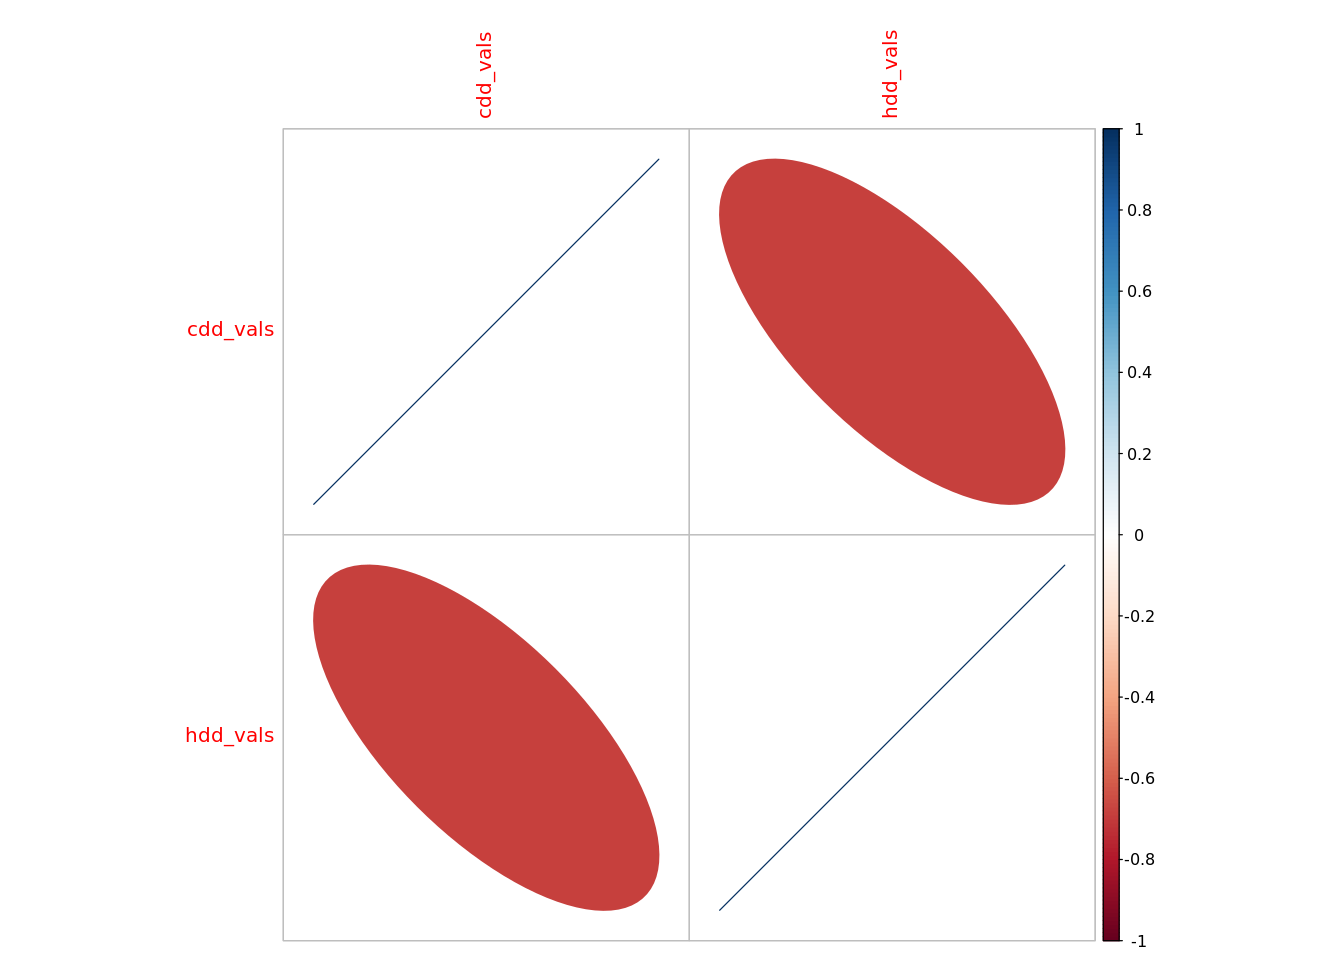

In [24]:
R <- cor(cdd_hdd[c('cdd_vals', 'hdd_vals')])
p1 <- corrplot(R, method="ellipse")    
# methods: “circle”, “square”, “ellipse”, “number”, “shade”, “color”, “pie”.